This script is a first experiment in analyzing multi-hazard impacts on the power grid

It uses the following approach:
- Identify power grid disturbances across power grid data sets
- Identify periods of 'extreme' disruption
- Selects data in a given area of interest from three hazards
    - wildfire
    - space weather
    - terrestrial weather (wind, precipitation, rain)
- Visualizes everything on a map
- Identifies simple compounding connections (same space and time)


Start with time periods
- 2014-2016 (balance of availability in power grid outage data, space weather activity, GIC data)


Start with area of interest
- California


In [39]:
import numpy as np
import pandas as pd
import os, sys

import geopandas as gpd


### Power grid disturbance data

Candidates
- [new dataset from EAGLE-I](https://www.nature.com/articles/s41597-024-03095-5) (Data are available in the Figshare repository at https://doi.org/10.6084/m9.figshare.24237376) 
- [DOE electric disturbance events OE-417](https://www.oe.netl.doe.gov/OE417_annual_summary.aspx)


In [15]:
# Read in 2014 data
outage_directory = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/outage_data/'
oe417 = pd.read_excel(os.path.join(outage_directory,'DOE-OE-417/2014_Annual_Summary.xlsx'),header=1)
oe417 = oe417.dropna(subset=['Time Event Began'])
oe417 = oe417.iloc[:-2]
# eaglei = pd.read_csv(os.path.join(outage_directory,'EAGLE-I/eaglei_outages_2014.csv'))


In [16]:
oe417

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Event Type,Demand Loss (MW),Number of Customers Affected
1,2014-01-06 00:00:00,19:50:00,2014-01-06 00:00:00,20:44:00,District of Columbia,RFC,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown
2,2014-01-06 00:00:00,19:50:00,2014-01-06 00:00:00,20:44:00,Unknown,RFC,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown
3,2014-01-06 00:00:00,19:52:00,2014-01-06 00:00:00,20:45:00,Delaware,RFC,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown
4,2014-01-06 00:00:00,20:45:00,2014-01-07 00:00:00,21:00:00,Unknown,RFC,Public Appeal due to Severe Weather - Cold,Unknown,Unknown
5,2014-01-06 00:00:00,19:50:00,2014-01-06 00:00:00,20:49:00,Pennsylvania,RFC,Voltage Reduction due to Severe Weather - Cold,200,62000
...,...,...,...,...,...,...,...,...,...
219,2014-12-11 00:00:00,07:21:00,2014-12-11 00:00:00,21:53:00,"San Francisco, California",WECC,Distribution Interruption - Unknown Cause,225,75000
220,2014-12-11 00:00:00,23:15:00,Unknown,Unknown,Northern California,WECC,Severe Weather- High Winds,Unknown,Unknown
221,2014-12-11 00:00:00,16:05:00,2014-12-11 00:00:00,21:00:00,"Portland, Oregon",WECC,Severe Weather- High Winds,250,85470
222,2014-12-11 00:00:00,17:00:00,2014-12-12 00:00:00,10:00:00,"Kitsap, Thurston, Whatcom counties Washington",WECC,Severe Weather- High Winds,116,264000


In [36]:
oe417 = oe417[oe417['Area Affected'].str.contains('California')]

In [20]:
eaglei = eaglei[eaglei['state'] == 'California']

In [25]:
for o in range(len(oe417['Number of Customers Affected'])):
    if oe417['Number of Customers Affected'].iloc[o]=='Unknown':
        oe417['Number of Customers Affected'].iloc[o] = np.nan
    
        

In [27]:
# Apply severity filters
oe417 = oe417[oe417['Number of Customers Affected']>1000]
eaglei = eaglei[eaglei['customers_out']>1000]


In [61]:
# Identify spatial areas of these candidate events (define the bounds of them as the regions they 
#   covered and consruct geopandas dataframes for them)

# oe417
gdf_states = gpd.read_file('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/location_data/Census_Bureau_Data/tl_2014_us_state/tl_2014_us_state.shp')
gdf_counties = gpd.read_file('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/location_data/Census_Bureau_Data/tl_2014_us_county/tl_2014_us_county.shp')



In [45]:
state = oe417['Area Affected'].iloc[-1]
state

'San Francisco, California'

13    MULTIPOLYGON (((-119.63472 33.26544, -119.6363...
Name: geometry, dtype: geometry


<Axes: >

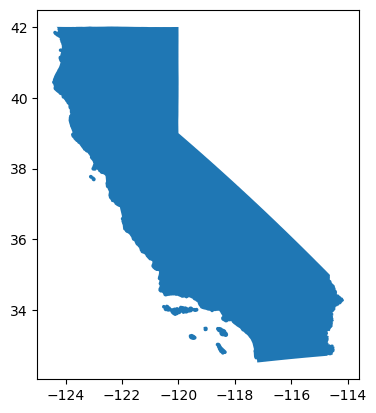

In [52]:
# Filter the GeoDataFrame by state name (example for 'California')
state_polygon = gdf_states[gdf_states['NAME'] == 'California']

# Display the polygon geometry
print(state_polygon.geometry)

state_polygon.plot()

In [64]:
gdf_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,NaN,NaN,NaN,A,1477895771,10447356,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,NaN,NaN,NaN,A,682138834,61658247,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,NaN,NaN,NaN,A,6015540562,29159485,+34.3592729,-104.3686961,"POLYGON ((-104.56746 33.99739, -104.57710 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,NaN,A,2169240148,22877213,+40.7835474,-096.6886584,"POLYGON ((-96.91060 40.95841, -96.91060 40.958..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,NaN,NaN,NaN,A,1489645230,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,NaN,NaN,NaN,A,1103983746,12186867,+34.6904951,-084.4546507,"POLYGON ((-84.65478 34.66559, -84.65488 34.669..."
3229,27,135,00659513,27135,Roseau,Roseau County,06,H1,G4020,NaN,NaN,NaN,A,4329419259,16925440,+48.7610683,-095.8215042,"POLYGON ((-96.40466 48.80528, -96.40467 48.813..."
3230,28,089,00695768,28089,Madison,Madison County,06,H1,G4020,298,27140,NaN,A,1850054742,71147843,+32.6343703,-090.0341603,"POLYGON ((-90.09363 32.70763, -90.09360 32.707..."
3231,48,227,01383899,48227,Howard,Howard County,06,H1,G4020,NaN,13700,NaN,A,2333038504,8841705,+32.3034712,-101.4387720,"POLYGON ((-101.69227 32.27106, -101.69221 32.2..."


636    MULTIPOLYGON (((-122.60024 37.80248, -122.6122...
Name: geometry, dtype: geometry


<Axes: >

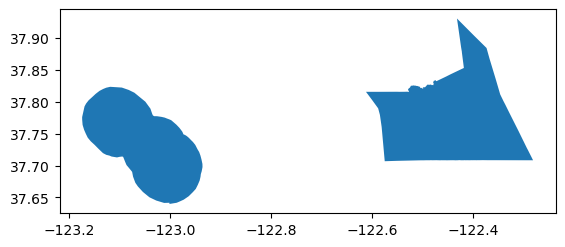

In [65]:
# Filter by both state and county name (example for 'Los Angeles County' in 'California')
county_polygon = gdf_counties[(gdf_counties['STATEFP'] == '06') & (gdf_counties['COUNTYFP']=='075')]

# Display the polygon geometry
print(county_polygon.geometry)

county_polygon.plot()

### Space Weather data

Candidates
- substorms events lists
- supermag optimally interpolated maps
- areas of aurora
- magnetometers in AoI above thresholds
- GICs directly



### Terrestrial Weather data

### Wildfire data

### Visualize spatial areas on common map